## Original Publication

See the original publication of this work in the following link: https://www.swsc-journal.org/articles/swsc/abs/2021/01/swsc210024/swsc210024.html

Aminalragia-Giamini, Sigiava, et al. "Solar Energetic Particle Event occurrence prediction using Solar Flare Soft X-ray measurements and Machine Learning." Journal of Space Weather and Space Climate 11 (2021): 59.


# Loading Data 

## Importing libraries and data files

In [ ]:
import os
import tensorflow as tf
import datetime
import sys
from os import path
import numpy as np
import pandas as pd
from tensorflow import keras 
import xgboost as xgb

x_train = pd.read_pickle("x_train.pkl")  
x_test = pd.read_pickle("x_test.pkl")  
y_train = pd.read_pickle("y_train.pkl")  
y_test = pd.read_pickle("y_test.pkl")  

# number of different classes
n_SEPS =  226
n_flares = 17875
n_sample = n_SEPS +n_flares
columns_to_use = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','17','20','21','22','28','39','40',
                       '41','42','43','44','45','46','47','48']
number_of_classes = 2 

## How SEPs & Flares look

Let'see some images though to see how things look 

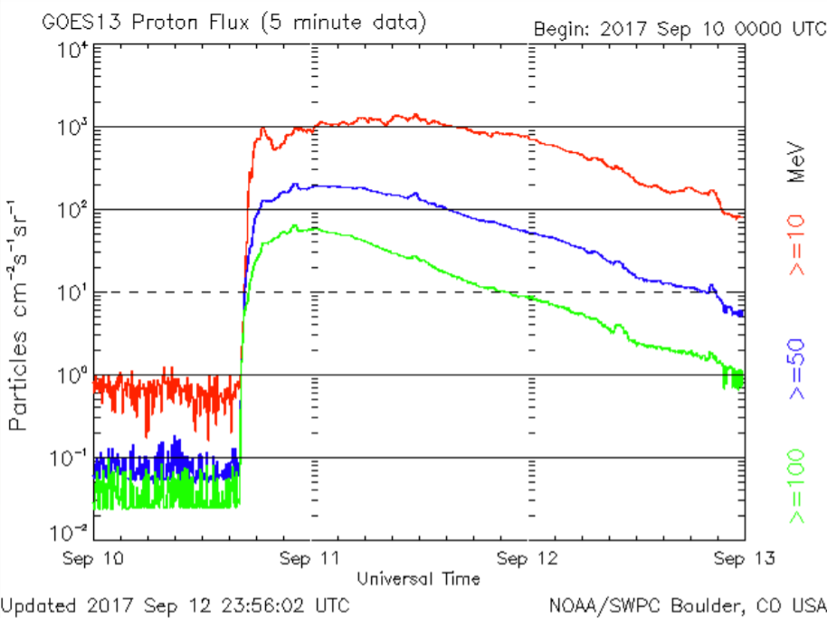

In [11]:
from IPython.display import Image
#Image(filename ='solar_flare.jpg')
Image(filename='GOES_SEP.png') 

## Split smaller dataset for flares

Since we have way too many flares we should split the training set to have fewer.

In [2]:
number_train_flares = 1500

x_train_SEPS = x_train.loc[y_train['class'] == 1] 
x_train_flares  = x_train.loc[y_train['class'] == 0] 

#Alternative way to calculate remaining flares
#x_train_rescaled_flares2 =  pd.concat([x_train_rescaled_SEPS,x_train_rescaled]).drop_duplicates(keep=False)

#undersampled_flares
x_train_undersampled_flares = x_train_flares.sample(number_train_flares,random_state=2)

#remaining flares to be added to test set
remaining_flares_x = x_train_flares.drop(x_train_undersampled_flares.index.values)
remaining_flares_and_seps_y = y_train.drop(x_train_undersampled_flares.index.values)
remaining_flares_y = remaining_flares_and_seps_y.drop(x_train_SEPS.index.values)

x_test = pd.concat([x_test,remaining_flares_x])
y_test = pd.concat([y_test,remaining_flares_y])

#y_train_rescaled_undersampled_flares = y_train_init.loc[x_train_rescaled_undersampled_flares.index.values]

# Create the new training set
x_train = pd.concat([x_train_undersampled_flares,x_train_SEPS])
y_train= y_train.loc[x_train.index.values]


y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

x_train_features = x_train[columns_to_use]
x_test_features = x_test[columns_to_use]



## Example of Model Setup

Let's setup a model below

In [3]:
import NN_models_SR 
import importlib
importlib.reload(NN_models_SR)
from NN_models_SR import simple_model
from NN_models_SR import deeper_model
from tensorflow.keras.utils import to_categorical

nin = len(x_train_features.columns)


SGD_2 = tf.keras.optimizers.SGD(
    learning_rate=0.005, momentum=0.5, nesterov=True
)

optimizer_choice_1 = 'Adam'
optimizer_choice_2 = SGD_2

scaling_factor = len(y_train[y_train[:,1] ==0])/len(y_train[y_train[:,1] ==1]) # we introduce a scaling factor equal to the ratio of the classes


model_used = simple_model(nin,number_of_classes,optimizer_choice_1,scaling_factor) # the class ratio is used directly in the model (in this example is better than changing weights)

class_weight_choice = {0: 1,
                1: scaling_factor}

## Example of Training proccedure


Let's now train our model

In [80]:
from sklearn.datasets import make_classification

d_train = xgb.DMatrix(x_train_features, label=y_train)
d_val = xgb.DMatrix(x_test_features, label=y_test)
eval_list = [(d_train, "train"), (d_val, "validation")]

 
bst=xgb.XGBClassifier(max_depth=100,learning_rate=0.05, n_estimators=500, objective='binary:logistic')
# fit model
model_used=bst.fit(x_train_features, y_train)

# Visualziating results (simple metrics)

Let's see the results

In [81]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = model_used.predict(x_test_features)
predictions_binary = np.argmax(predictions, axis = 1)
y_test_binary = np.argmax(y_test, axis=1)
    
cr = classification_report(y_test_binary, predictions_binary)
cm = confusion_matrix(y_test_binary, predictions_binary)

print(cm)
print("Class 1 accuracy")
print(cm[0,0]/(cm[0,0]+cm[0,1]))

print("Class 2 accuracy")
print(cm[1,1]/(cm[1,0]+cm[1,1]))

#print(model_used.summary())
print(cr)

[[16037   338]
 [    3    20]]
Class 1 accuracy
0.9793587786259542
Class 2 accuracy
0.8695652173913043
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16375
           1       0.06      0.87      0.10        23

    accuracy                           0.98     16398
   macro avg       0.53      0.92      0.55     16398
weighted avg       1.00      0.98      0.99     16398



# Visualziating results (Plots)

Let's see the results

In [63]:
import matplotlib.pyplot as plt

val_f1 = history.history['val_f1_m']
val_loss= history.history['val_loss']
val_acc= history.history['val_acc']
val_prec= history.history['val_precision_m']

train_f1 = history.history['f1_m']
train_loss = history.history['loss']
train_acc = history.history['acc']
train_prec = history.history['precision_m']

plt.figure(figsize=(11.69,8.27))
plt.subplot(2, 2, 1)
plt.plot(train_f1)
plt.plot(val_f1)
plt.ylabel('f1 score',fontsize=22)
plt.legend(['train', 'test'], loc='lower right',fontsize=16)

plt.subplot(2, 2, 2)
plt.plot(train_loss)
plt.plot(val_loss)
plt.ylabel('loss',fontsize=22)

plt.subplot(2, 2, 3)
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epochs',fontsize=22)
plt.ylabel('acc',fontsize=22)

plt.subplot(2, 2, 4)
plt.plot(train_prec)
plt.plot(val_prec)
plt.xlabel('epochs',fontsize=22)
plt.ylabel('precision',fontsize=22)

plt.show()



AttributeError: 'XGBClassifier' object has no attribute 'history'